# Network and Hierarchical Portfolios on the FTSE 100

This project studies portfolio construction on FTSE 100 equities using methods that make explicit use of the correlation structure between stocks. Using daily data from 2015–2025, we compare classical Markowitz portfolios with network-based and hierarchical portfolios built from a data-driven correlation network. All portfolios are calibrated on 2015–2017 and then evaluated out-of-sample over 2018–2025, with the FTSE 100 index as the benchmark.

The idea is to start from a simple reference point (standard meanvariance optimization) and then ask whether we can obtain more robust portfolios by using the empirical correlation network instead of relying only on a flat covariance matrix. In practice this means:

* Constructing Markowitz minimum-variance and maximum-Sharpe portfolios as a baseline.
* Building network portfolios from a thresholded correlation graph (degeneracy, clique, eigenvector centrality).
* Building hierarchical portfolios from a distance-based clustering of stocks (cluster equal-weight, hierarchical 1/N, HRP, HERC).
* Estimating all weights once in 2015–2017 and then holding the portfolios long-only from 2018–2025 in a buy-and-hold.
* Comparing realized performance to the FTSE 100 index in terms of annualised return, volatility, Sharpe ratio, maximum drawdown and tracking error.

In other words, we ask whether “leaning into the network” and spreading risk across clusters of weakly connected stocks can protect us from the instabilities of a pure Markowitz approach that is heavily driven by noisy mean and covariance estimates. Can network-based and hierarchical portfolios that are constructed from the empirical FTSE 100 correlation network deliver better out of sample risk/return tradeoffs than standard Markowitz portfolios and the FTSE 100 benchmark, by diversifying away concentrated sources of risk rather than optimizing purely on estimated means and covariances?

## Setup and Configuration


In [37]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List, Dict
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)

In [38]:
IN_SAMPLE_START = '2015'
IN_SAMPLE_END = '2017'
OUT_SAMPLE_START = '2018'
OUT_SAMPLE_END = '2025'
MIN_DATA_AVAILABILITY = 0.90
NETWORK_THRESHOLD_QUANTILE = 0.80
CENTRALITY_THRESHOLD = 20
HIER_MAX_CLUSTERS = 4
HERC_MAX_DEPTH = 3
PERIODS_PER_YEAR = 252


### Model Configuration

The following table summarises key hyperparameters and configuration choices used throughout the analysis:

| Parameter | Value | Description |
|-----------|-------|-------------|
| In-sample period | 2015–2017 | Training period for estimating covariances and constructing portfolios |
| Out-of-sample period | 2018–2025 | Evaluation period with frozen portfolio weights |
| Min data availability | 90% | Minimum fraction of stocks with valid prices required per trading day |
| Network threshold quantile | 0.80 | Percentile of correlation distribution used for network edge threshold |
| Centrality threshold | 20 | Minimum clique membership count for clique portfolio selection |
| Hierarchical clusters | 4 | Number of clusters for cluster-equal portfolio |
| HERC max depth | 3 | Maximum recursion depth for HERC portfolio (early stopping) |
| Periods per year | 252 | Trading days per year for annualisation |


## 1. Data and Preprocessing

We work with daily closing prices for FTSE 100 constituents and the FTSE 100 index.

- Universe: Current or historical FTSE 100 members. We treat this set as fixed over 2015–2025, which introduces survivorship bias.
- Frequency: Daily closes.
- Sample:
  - In-sample: 2015–2017 (used to estimate covariances and build portfolios). After filtering for 90% data availability, we work with 95 stocks over approximately 756 trading days.
  - Out-of-sample: 2018–2025 (used only to evaluate performance). Over approximately 1,980 trading days.

Preprocessing steps

1. Keep only stocks that have some price data in the period.
2. For each day, require at least 90% of stocks to have a valid price. If this condition fails, we drop that day. This avoids days where the data is too sparse.
3. Forward-fill occasional missing prices, then drop initial rows that are still incomplete.
4. Compute daily percentage returns and the corresponding correlation matrix.

These steps help produce more reliable correlation and covariance estimates for portfolio construction.


In [39]:
def preprocess_returns(data: pd.DataFrame, components: List[str], min_data_availability: float = 0.9) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    
    available_components = [c for c in components if c in data.columns]
    if len(available_components) == 0:
        raise ValueError("No components found in data.columns")
    
    data_subset = data[available_components]
    has_data = ~data_subset.isnull().all()
    components_with_data = [c for c in available_components if has_data[c]]
    
    if len(components_with_data) == 0:
        raise ValueError("No stocks have data in the specified period")
    
    non_null_count = data_subset[components_with_data].notna().sum(axis=1)
    total_stocks = len(components_with_data)
    available_pct = non_null_count / total_stocks
    
    valid_dates = available_pct >= min_data_availability
    data_filtered = data_subset[components_with_data].loc[valid_dates].copy()
    
    if len(data_filtered) == 0:
        raise ValueError(f"No dates have at least {min_data_availability*100:.0f}% data availability")
    
    data_filled = data_filtered.ffill()
    
    data_filled = data_filled.dropna()
    
    pctreturn = data_filled.pct_change().dropna()
    
    correlation = pctreturn.corr()
    
    return pctreturn, correlation, data_filled


### Performance Metrics

We evaluate portfolio performance using three annualised metrics computed from daily returns. We report all performance numbers at the daily frequency and then annualise them using 252 trading days per year.

Annualised Mean Return:
$$\mu_{\text{annual}} = 252 \times \bar{r}$$

where $\bar{r} = \frac{1}{T} \sum_{t=1}^T r_t$ is the sample mean of daily returns.

Annualised Volatility:
$$\sigma_{\text{annual}} = \sqrt{252} \times \hat{\sigma}$$

where $\hat{\sigma} = \sqrt{\frac{1}{T-1} \sum_{t=1}^T (r_t - \bar{r})^2}$ is the sample standard deviation of daily returns.

Sharpe Ratio (assuming risk-free rate = 0):
$$\text{Sharpe} = \frac{\mu_{\text{annual}}}{\sigma_{\text{annual}}} = \frac{\bar{r}}{\hat{\sigma}} \sqrt{252}$$

The Sharpe ratio measures risk-adjusted returns, with higher values indicating better risk-adjusted performance.


In [40]:
# Note: if some stocks are missing in OOS, weights are renormalised over remaining names.
def compute_weighted_portfolio(data: pd.DataFrame, weights: pd.Series, name: str = 'markowitz') -> pd.Series:
    common = [c for c in weights.index if c in data.columns]
    if not common:
        return pd.Series(0.0, index=data.index, name=name)
    w = weights[common].values
    if w.sum() != 0:
        w = w / w.sum()
    portfolio = (data[common] * w).sum(axis=1)
    portfolio.name = name
    return portfolio

def compute_equal_weighted_portfolio(data: pd.DataFrame, selected_stocks: List[str], name: str = 'portfolio') -> pd.Series:
    if not selected_stocks:
        return pd.Series(0, index=data.index, name=name)
    portfolio = data[selected_stocks].mean(axis=1)
    portfolio.name = name
    return portfolio

def compute_performance_metrics(returns: pd.Series, periods_per_year: int = 252) -> Dict[str, float]:
    if len(returns) == 0 or returns.std() == 0:
        return {'mean_return': 0.0, 'volatility': 0.0, 'sharpe_ratio': 0.0}
    mean_return = returns.mean() * periods_per_year
    volatility = returns.std() * np.sqrt(periods_per_year)
    sharpe_ratio = mean_return / volatility if volatility > 0 else 0.0
    return {'mean_return': mean_return, 'volatility': volatility, 'sharpe_ratio': sharpe_ratio}

def max_drawdown(series: pd.Series) -> float:
    
    if len(series) == 0:
        return 0.0
    cum = (1 + series).cumprod()
    peak = cum.cummax()
    dd = (cum - peak) / peak
    return dd.min()

def tracking_error(port_ret: pd.Series, bench_ret: pd.Series, periods_per_year: int = 252) -> float:
    
    common_idx = port_ret.index.intersection(bench_ret.index)
    if len(common_idx) == 0:
        return 0.0
    diff = port_ret[common_idx] - bench_ret[common_idx]
    return diff.std() * np.sqrt(periods_per_year)



In [41]:
def corr_distance_matrix(correlation: pd.DataFrame) -> np.ndarray:
    
    corr_values = correlation.values.copy()
    np.fill_diagonal(corr_values, 1.0)
    distance = np.sqrt(0.5 * (1 - corr_values))
    np.fill_diagonal(distance, 0.0)
    return distance

def corr_distance_of_distance_matrix(correlation: pd.DataFrame) -> np.ndarray:
    
    D = corr_distance_matrix(correlation)
    
    n = D.shape[0]
    Dtilde = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i + 1, n):
            dist = np.linalg.norm(D[:, i] - D[:, j])
            Dtilde[i, j] = dist
            Dtilde[j, i] = dist
    
    np.fill_diagonal(Dtilde, 0.0)
    return Dtilde


In [42]:
def load_ftse100_data(csv_file: str = 'ftse_stock_prices.csv') -> Tuple[pd.DataFrame, List[str]]:
    
    df = pd.read_csv(csv_file)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    
    components = [col for col in df.columns if col != 'FTSE100' and col != '.FTSE']
    if '.FTSE' in df.columns:
        df = df.rename(columns={'.FTSE': 'FTSE100'})
    
    metadata = df.copy()
    return metadata, components

metadata, components = load_ftse100_data('ftse_stock_prices.csv')
print(f"Loaded data for {len(components)} stocks")
print(f"Date range: {metadata.index.min()} to {metadata.index.max()}")
print(f"FTSE100 index included: {'FTSE100' in metadata.columns}")

# Display preview: headers, first 3 rows, and last 3 rows
print("\n" + "="*80)
print("Data Preview (First 3 and Last 3 rows):")
print("="*80)
print("\nColumn headers:")
print(list(metadata.columns[:10]) + ["..."] if len(metadata.columns) > 10 else list(metadata.columns))
print(f"\nFirst 3 rows:")
print(metadata.head(3))
print(f"\nLast 3 rows:")
print(metadata.tail(3))


Loaded data for 100 stocks
Date range: 2015-01-02 00:00:00 to 2025-12-05 00:00:00
FTSE100 index included: True

Data Preview (First 3 and Last 3 rows):

Column headers:
['KGF.L', 'DPLM.L', 'BP.L', 'RR.L', 'SMT.L', 'SGE.L', 'GLEN.L', 'GSK.L', 'BTRW.L', 'AV.L', '...']

First 3 rows:
            KGF.L  DPLM.L    BP.L        RR.L  SMT.L  SGE.L      GLEN.L  \
Date                                                                      
2015-01-02  336.3   714.0  410.45  272.373773  246.4  467.8  283.011475   
2015-01-05  328.1   718.0  389.70  268.908057  242.0  467.8  269.103809   
2015-01-06  316.8   725.0  391.05  269.065589  241.5  459.8  270.627936   

                  GSK.L      BTRW.L        AV.L  ...   SVT.L      SGRO.L  \
Date                                             ...                       
2015-01-02  1377.296746  405.280259  478.588302  ...  2000.0  363.103612   
2015-01-05  1363.852418  402.199953  465.151471  ...  1988.0  366.067333   
2015-01-06  1351.403966  393.927131  4

### Sample Split and Benchmark

We use the FTSE 100 index (FTSE100 column) as our benchmark.

- In-sample (2015–2017): We estimate all covariance matrices and construct the network and hierarchical portfolios.
- Out-of-sample (2018–2025): All portfolio compositions are fixed based on in-sample estimates and then held buy-and-hold from 2018–2025 (no rebalancing). In practice, this means we fix the relative exposures at the start and then let the weights drift as prices move.

Note: The FTSE index itself is rebalanced over time, so there is a small mismatch vs our static universe, but this is acceptable for this analysis.


In [43]:
in_sample_start = IN_SAMPLE_START
in_sample_end = IN_SAMPLE_END
out_sample_start = OUT_SAMPLE_START
out_sample_end = OUT_SAMPLE_END
centrality = CENTRALITY_THRESHOLD

in_sample_data = metadata[in_sample_start:in_sample_end].copy()
in_sample_returns, in_sample_correlation, in_sample_prices = preprocess_returns(
    in_sample_data, components, min_data_availability=MIN_DATA_AVAILABILITY
)

in_sample_data = in_sample_prices.copy()

in_sample_data['FTSE100'] = metadata.loc[in_sample_data.index, 'FTSE100'].ffill()

components = list(in_sample_returns.columns)
print(f"Using {len(components)} stocks with data in the in-sample period")


Using 95 stocks with data in the in-sample period


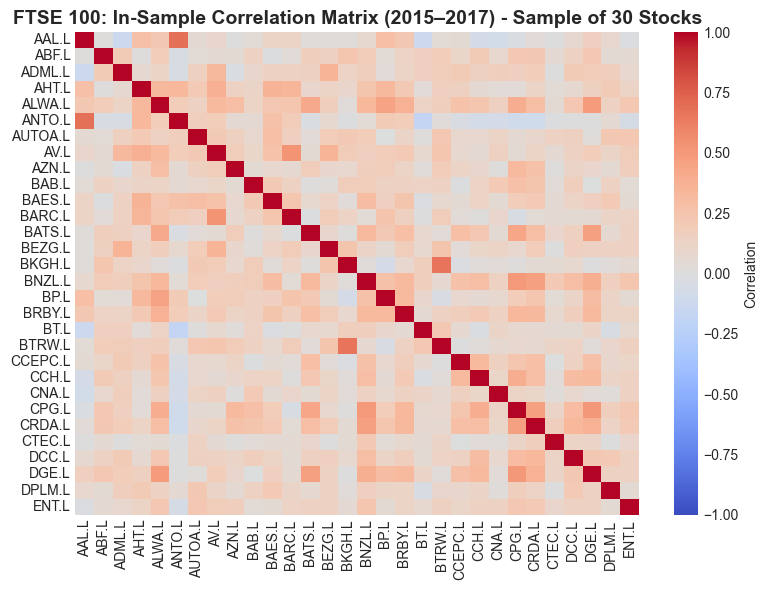

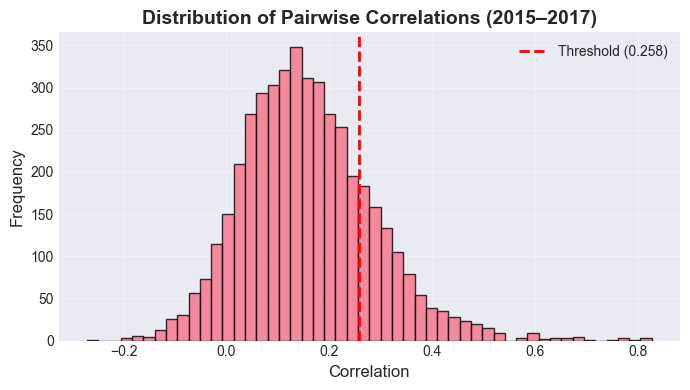

Correlation statistics:

  Mean correlation: 0.159
  Median correlation: 0.147
  Std correlation: 0.128
  Threshold q=0.80 corresponds to 0.258


In [44]:

fig, ax = plt.subplots(figsize=(8, 6))
sorted_stocks = sorted(in_sample_correlation.index)[:30]
corr_subset = in_sample_correlation.loc[sorted_stocks, sorted_stocks]
sns.heatmap(corr_subset, cmap='coolwarm', center=0, vmin=-1, vmax=1,
            xticklabels=True, yticklabels=True, ax=ax, 
            cbar_kws={'label': 'Correlation'})
ax.set_title('FTSE 100: In-Sample Correlation Matrix (2015–2017) - Sample of 30 Stocks', fontsize=14, fontweight='bold')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

corr_vals = in_sample_correlation.values
upper = corr_vals[np.triu_indices_from(corr_vals, k=1)]
upper = upper[~np.isnan(upper)]

threshold_quantile = NETWORK_THRESHOLD_QUANTILE
threshold = np.quantile(upper, threshold_quantile)

fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(upper, bins=50, alpha=0.8, edgecolor='black')
ax.axvline(threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold ({threshold:.3f})')
ax.set_xlabel('Correlation', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Pairwise Correlations (2015–2017)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Correlation statistics:\n")
print(f"  Mean correlation: {upper.mean():.3f}")
print(f"  Median correlation: {np.median(upper):.3f}")
print(f"  Std correlation: {upper.std():.3f}")
print(f"  Threshold q={threshold_quantile:.2f} corresponds to {threshold:.3f}")


Interpretation

- The in-sample correlation matrix shows clear clusters, which roughly look like sector groups (for example banks, oil and gas, consumer staples, utilities).
- Average pairwise correlations are quite low (mean around 0.16, median around 0.15). This matches the idea that FTSE 100 stocks have moderate co-movement.
- A fixed threshold of 0.6 would sit around the 99.5th percentile of this distribution. The resulting network would have almost no edges.
- Instead, we use the 80th percentile (around ρ ≈ 0.26). This keeps only the strongest 20% of correlations and produces a network that is dense enough to be interesting but still easy to interpret.


## 2. Portfolio Construction

Overview of Portfolio Methods

The following table summarises all portfolio construction methods used in this analysis:

| Portfolio            | Type          | Key idea                                  |
|----------------------|---------------|-------------------------------------------|
| FTSE 100             | Benchmark     | Cap-weighted UK equity index              |
| Markowitz Min-Var    | Mean–variance | Minimise variance given Σ                 |
| Markowitz Max-Sharpe | Mean–variance | Maximise Sharpe using μ, Σ               |
| Degeneracy           | Network       | Independent set in thresholded graph     |
| Clique               | Network       | Hub stocks in many cliques                |
| Eigen Centrality     | Network       | Weights ∝ eigenvector centrality          |
| Cluster Equal        | Hierarchical  | Equal weight across clusters, then stocks|
| Hierarchical 1/N     | Hierarchical  | 50–50 splits along dendrogram             |
| HRP                  | Hierarchical  | Inverse-variance splits along tree        |
| HERC                 | Hierarchical  | Equal risk contribution up to depth       |

### 2.1 Markowitz Mean-Variance Optimisation

Intuitively, the idea is very simple: the minimum-variance portfolio tries to make returns as smooth as possible (low risk), while the maximum-Sharpe portfolio tries to achieve the highest average return per unit of risk.

The Markowitz (1952) framework forms the foundation of modern portfolio theory. We implement two variants:

#### 2.1.1 Minimum-Variance Portfolio

The global minimum-variance portfolio minimises portfolio variance subject to the constraint that weights sum to one:

$$\min_{\mathbf{w}} \mathbf{w}^T \boldsymbol{\Sigma} \mathbf{w} \quad \text{subject to} \quad \mathbf{1}^T \mathbf{w} = 1$$

The solution is:

$$\mathbf{w}_{\text{minvar}} = \frac{\boldsymbol{\Sigma}^{-1} \mathbf{1}}{\mathbf{1}^T \boldsymbol{\Sigma}^{-1} \mathbf{1}}$$

where $\boldsymbol{\Sigma}$ is the covariance matrix of returns, and $\mathbf{1}$ is a vector of ones.

#### 2.1.2 Maximum-Sharpe Portfolio

The maximum-Sharpe portfolio maximises the risk-adjusted return (Sharpe ratio), assuming a risk-free rate of zero:

$$\max_{\mathbf{w}} \frac{\boldsymbol{\mu}^T \mathbf{w}}{\sqrt{\mathbf{w}^T \boldsymbol{\Sigma} \mathbf{w}}} \quad \text{subject to} \quad \mathbf{1}^T \mathbf{w} = 1$$

The solution is:

$$\mathbf{w}_{\text{maxsharpe}} = \frac{\boldsymbol{\Sigma}^{-1} \boldsymbol{\mu}}{\mathbf{1}^T \boldsymbol{\Sigma}^{-1} \boldsymbol{\mu}}$$

where $\boldsymbol{\mu}$ is the vector of expected returns.

Implementation Note: In the implementation, we enforce long-only weights by truncating negative entries of the unconstrained solution at zero and renormalising. This is a heuristic projection onto the long-only simplex, not the exact constrained Markowitz solution (which would require solving a quadratic programming problem with inequality constraints).


In [45]:
def compute_markowitz_weights(returns: pd.DataFrame, allow_short: bool = False) -> Tuple[pd.Series, pd.Series]:
    returns = returns.dropna(axis=1, how='all')
    mu = returns.mean()
    Sigma = returns.cov()
    Sigma_inv = np.linalg.pinv(Sigma.values)
    ones = np.ones(len(mu))
    w_minvar = Sigma_inv @ ones
    denom_minvar = ones @ w_minvar
    if denom_minvar != 0:
        w_minvar = w_minvar / denom_minvar
    w_maxsharpe = Sigma_inv @ mu.values
    denom_maxsharpe = w_maxsharpe.sum()
    if denom_maxsharpe != 0:
        w_maxsharpe = w_maxsharpe / denom_maxsharpe
    if not allow_short:
        w_minvar = np.maximum(w_minvar, 0.0)
        if w_minvar.sum() > 0:
            w_minvar = w_minvar / w_minvar.sum()
        w_maxsharpe = np.maximum(w_maxsharpe, 0.0)
        if w_maxsharpe.sum() > 0:
            w_maxsharpe = w_maxsharpe / w_maxsharpe.sum()
    w_minvar = pd.Series(w_minvar, index=mu.index, name='markowitz_minvar')
    w_maxsharpe = pd.Series(w_maxsharpe, index=mu.index, name='markowitz_maxsharpe')
    return w_minvar, w_maxsharpe

minvar_w, maxsharpe_w = compute_markowitz_weights(in_sample_returns, allow_short=False)
in_sample_data['markowitz_minvar'] = compute_weighted_portfolio(in_sample_data, minvar_w, 'markowitz_minvar')
in_sample_data['markowitz_maxsharpe'] = compute_weighted_portfolio(in_sample_data, maxsharpe_w, 'markowitz_maxsharpe')

print("Minimum-Variance Portfolio:")
print("=" * 70)
print(f"Number of stocks: {(minvar_w > 0.001).sum()}")
print("\nTop 3 and Bottom 3 holdings:")
top_minvar_all = minvar_w[minvar_w > 0.001].sort_values(ascending=False)
top_minvar = top_minvar_all.head(3)
bottom_minvar = top_minvar_all.tail(3)
for stock, weight in top_minvar.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("  ...")
for stock, weight in bottom_minvar.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("\n" + "=" * 70)

print("\nMaximum-Sharpe Portfolio:")
print("=" * 70)
print(f"Number of stocks: {(maxsharpe_w > 0.001).sum()}")
print("\nTop 3 and Bottom 3 holdings:")
top_maxsharpe_all = maxsharpe_w[maxsharpe_w > 0.001].sort_values(ascending=False)
top_maxsharpe = top_maxsharpe_all.head(3)
bottom_maxsharpe = top_maxsharpe_all.tail(3)
for stock, weight in top_maxsharpe.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("  ...")
for stock, weight in bottom_maxsharpe.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("=" * 70)


Minimum-Variance Portfolio:
Number of stocks: 52

Top 3 and Bottom 3 holdings:
  ALWA.L                 7.20%
  SSE.L                  7.07%
  FCIT.L                 5.17%
  ...
  BTRW.L                 0.29%
  BAB.L                  0.28%
  HLMA.L                 0.19%


Maximum-Sharpe Portfolio:
Number of stocks: 42

Top 3 and Bottom 3 holdings:
  REL.L                  6.98%
  ALWA.L                 6.64%
  SGRO.L                 6.51%
  ...
  RTO.L                  0.28%
  KGF.L                  0.24%
  HSBA.L                 0.20%


Network Threshold Choice.

For the FTSE 100, pairwise correlations are relatively low (mean ≈ 0.16, median ≈ 0.15). A fixed threshold of 0.6 would correspond to about the 99.5th percentile and produce an almost empty network. Instead, we use a data-driven threshold equal to the 80th percentile of the in-sample correlation distribution. Edges connect the top 20% most strongly correlated pairs, which yields a richer network and makes the degeneracy and clique portfolios economically meaningful.


### 2.2 Network Portfolios

#### 2.2.1 Degeneracy Ordering Portfolio

This method constructs an independent vertex set in the correlation network. An independent set is a subset of nodes where no two nodes are connected by an edge, ensuring low pairwise correlations.

Algorithm:
1. Compute k-core numbers for all nodes using k-core decomposition
2. Sort nodes by core number (ascending)
3. Greedily select nodes such that no selected node is adjacent to any previously selected node

Result: A diversified portfolio where selected stocks have minimal direct correlations, as they are not connected in the thresholded correlation network.

In [46]:
def create_graph(components: List[str], correlation: pd.DataFrame, 
                 threshold: float) -> Tuple[nx.Graph, Dict]:
    
    graph = nx.Graph()
    valid_components = [c for c in components if c in correlation.index and c in correlation.columns]
    graph.add_nodes_from(valid_components)
    
    for i in range(len(valid_components)):
        for j in range(i + 1, len(valid_components)):
            stock_i = valid_components[i]
            stock_j = valid_components[j]
            if stock_i in correlation.index and stock_j in correlation.columns:
                corr_val = correlation.loc[stock_i, stock_j]
                if corr_val > threshold:
                    graph.add_edge(stock_i, stock_j, weight=corr_val)
    
    layout = nx.spring_layout(graph, seed=42) if len(graph.nodes) > 0 else {}
    return graph, layout

def create_full_correlation_graph(components: List[str], correlation: pd.DataFrame) -> nx.Graph:
    
    graph = nx.Graph()
    valid_components = [c for c in components if c in correlation.index and c in correlation.columns]
    graph.add_nodes_from(valid_components)
    
    for i in range(len(valid_components)):
        for j in range(i + 1, len(valid_components)):
            stock_i = valid_components[i]
            stock_j = valid_components[j]
            if stock_i in correlation.index and stock_j in correlation.columns:
                corr_val = correlation.loc[stock_i, stock_j]
                weight = max(corr_val, 0.0)
                if weight > 0:
                    graph.add_edge(stock_i, stock_j, weight=weight)
    return graph


In [47]:
def degeneracy_ordering(graph: nx.Graph, components: List[str]) -> Tuple[List[str], List[str]]:
    degeneracy = dict(sorted(nx.core_number(graph).items(), key=lambda x: x[1]))
    independence = []
    for i in degeneracy:
        if not set(graph.neighbors(i)).intersection(set(independence)):
            independence.append(i)
    leftout = [i for i in components if i not in graph.nodes]
    return independence, leftout


In [48]:
in_sample_graph, in_sample_layout = create_graph(components, in_sample_correlation, threshold)
in_sample_full_graph = create_full_correlation_graph(components, in_sample_correlation)

### Network Diagnostics

The data-driven threshold ensures a meaningful network structure for the degeneracy and clique portfolios. Below we report key network statistics: number of nodes and edges, edge density (fraction of possible edges that exist), and average node degree. These metrics confirm that the 80th percentile threshold produces a non-trivial network topology, unlike a fixed threshold of 0.6 which would result in an almost empty graph for FTSE 100 data.


In [49]:
deg = dict(in_sample_graph.degree())
num_nodes = in_sample_graph.number_of_nodes()
num_edges = in_sample_graph.number_of_edges()
avg_degree = np.mean(list(deg.values())) if len(deg) > 0 else 0.0
edge_density = 2 * num_edges / (num_nodes * (num_nodes - 1)) if num_nodes > 1 else 0.0

print(f"Network stats (threshold q={threshold_quantile:.2f}, rho={threshold:.3f}):")
print(f"  Nodes: {num_nodes}")
print(f"  Edges: {num_edges}")
print(f"  Edge density: {edge_density:.4f}")
print(f"  Avg degree: {avg_degree:.2f}")


Network stats (threshold q=0.80, rho=0.258):
  Nodes: 95
  Edges: 893
  Edge density: 0.2000
  Avg degree: 18.80


In [50]:
independence, leftout = degeneracy_ordering(in_sample_graph, components)
in_sample_data['degeneracy'] = compute_equal_weighted_portfolio(in_sample_data, leftout + independence, 'degeneracy')

selected_stocks = leftout + independence
print("Degeneracy Portfolio:")
print("=" * 70)
print(f"Total stocks selected: {len(selected_stocks)}")
print(f"  - Stocks not in network (leftout): {len(leftout)}")
print(f"  - Independent set from network: {len(independence)}")
print("\nTop 3 and Bottom 3 selected stocks:")
if len(selected_stocks) > 6:
    top_three = selected_stocks[:3]
    bottom_three = selected_stocks[-3:]
    for i, stock in enumerate(top_three, 1):
        print(f"  {i:2d}. {stock}")
    print("  ...")
    for idx, stock in enumerate(bottom_three):
        i = len(selected_stocks) - 2 + idx
        print(f"  {i:2d}. {stock}")
else:
    for i, stock in enumerate(selected_stocks, 1):
        print(f"  {i:2d}. {stock}")
print("=" * 70)

Degeneracy Portfolio:
Total stocks selected: 28
  - Stocks not in network (leftout): 0
  - Independent set from network: 28

Top 3 and Bottom 3 selected stocks:
   1. PSON.L
   2. CTEC.L
   3. GAW.L
  ...
  26. BP.L
  27. HLMA.L
  28. MRON.L


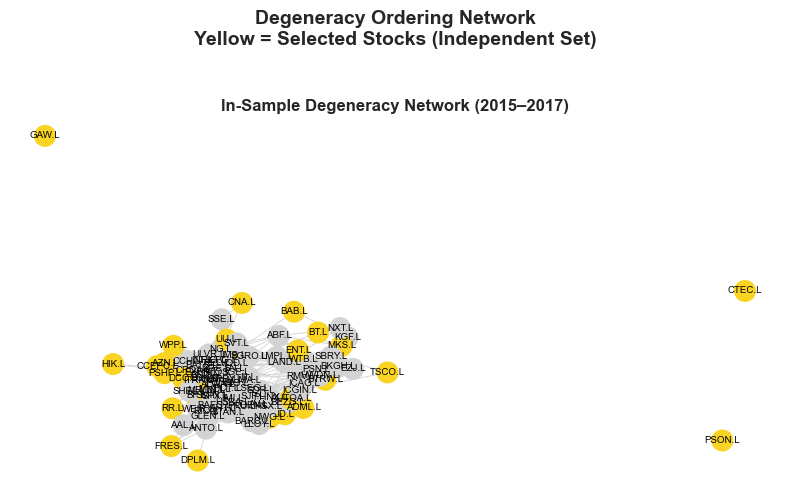

In [51]:
def draw_degeneracy_network(ax, graph, layout, selected, title):
    if len(graph.nodes) == 0:
        ax.text(0.5, 0.5, 'Empty Graph', ha='center', va='center',
                transform=ax.transAxes)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.axis('off')
        return
    
    node_colors = ['#F9D423' if n in selected else '#D3D3D3' for n in graph.nodes]
    nx.draw(
        graph,
        pos=layout,
        node_color=node_colors,
        node_size=220,
        with_labels=True,
        font_size=7,
        edge_color='lightgray',
        width=0.6,
        ax=ax
    )
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.axis('off')

fig, ax = plt.subplots(figsize=(8, 5))
fig.suptitle('Degeneracy Ordering Network\nYellow = Selected Stocks (Independent Set)',
             fontsize=14, fontweight='bold', y=0.98)

draw_degeneracy_network(
    ax,
    in_sample_graph,
    in_sample_layout,
    independence,
    'In-Sample Degeneracy Network (2015–2017)'
)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

What the degeneracy network shows

- The thresholded network has a non-trivial number of nodes and edges. The edge density and average degree (reported above) confirm that the 80th percentile threshold gives a meaningful graph.
- The degeneracy portfolio selects stocks that have no strong links to each other in this graph, plus stocks that are completely disconnected. By construction, there are no edges between chosen names.
- Economically, this is a "low direct correlation" portfolio. It tries to spread risk across many parts of the network and avoid strong overlaps.
- This provides a useful contrast with the clique and eigenvector portfolios, which tilt towards more central or "hub" stocks.


#### 2.2.2 Clique Centrality Portfolio

This method identifies "hub" stocks that belong to many maximal cliques (complete subgraphs). A maximal clique is a set of nodes that form a complete subgraph and cannot be extended by adding another node.

Algorithm:
1. Find all maximal cliques in the correlation network
2. Count clique membership: $c_i = |\{C : i \in C, C \text{ is a maximal clique}\}|$
3. Select stocks with $c_i > \theta$ (threshold $\theta$)

Result: A portfolio concentrated on systemically important stocks that are central to multiple highly correlated groups.

In [52]:
def clique_centrality(graph: nx.Graph, centrality: int = 10, top_k: int = 10) -> List[str]:
    cliques = list(nx.find_cliques(graph))
    if not cliques:
        return []
    
    flat_nodes = [j for i in cliques for j in i]
    counts = {}
    for node in set(flat_nodes):
        counts[node] = flat_nodes.count(node)
    
    selected = [node for node, c in counts.items() if c > centrality]
    
    if not selected:
        selected = [node for node, _ in sorted(counts.items(),
                                               key=lambda x: x[1],
                                               reverse=True)[:top_k]]
    return selected

In [53]:
clique_selected = clique_centrality(in_sample_graph, centrality)
in_sample_data['clique'] = compute_equal_weighted_portfolio(in_sample_data, clique_selected, 'clique')

print("Clique Centrality Portfolio:")
print("=" * 70)
print(f"Total stocks selected: {len(clique_selected)}")
print("\nTop 3 and Bottom 3 selected stocks (hub stocks in multiple cliques):")
if len(clique_selected) > 6:
    top_three = clique_selected[:3]
    bottom_three = clique_selected[-3:]
    for i, stock in enumerate(top_three, 1):
        print(f"  {i:2d}. {stock}")
    print("  ...")
    for idx, stock in enumerate(bottom_three):
        i = len(clique_selected) - 2 + idx
        print(f"  {i:2d}. {stock}")
else:
    for i, stock in enumerate(clique_selected, 1):
        print(f"  {i:2d}. {stock}")
print("=" * 70)

Clique Centrality Portfolio:
Total stocks selected: 38

Top 3 and Bottom 3 selected stocks (hub stocks in multiple cliques):
   1. FCIT.L
   2. BNZL.L
   3. BP.L
  ...
  36. SMIN.L
  37. RIO.L
  38. SGE.L


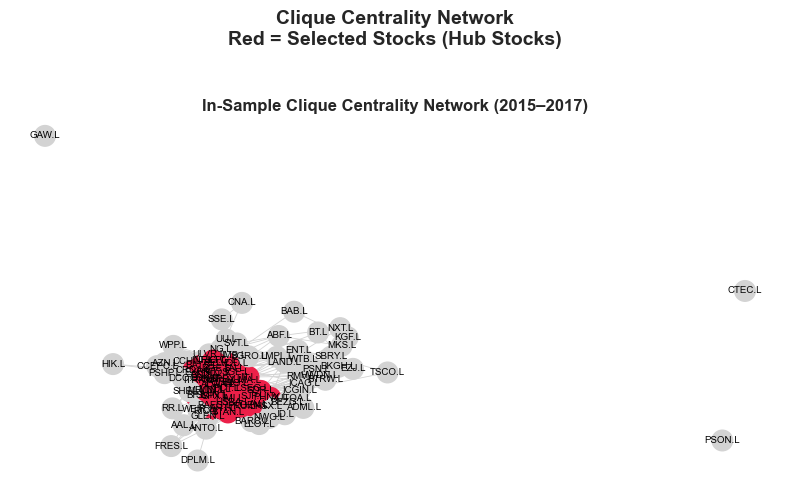

In [54]:

def draw_clique_network(ax, graph, layout, selected, title):
    if len(graph.nodes) == 0:
        ax.text(0.5, 0.5, 'Empty Graph', ha='center', va='center',
                transform=ax.transAxes)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.axis('off')
        return
    
    node_colors = ['#EC2049' if n in selected else '#D3D3D3' for n in graph.nodes]
    nx.draw(
        graph,
        pos=layout,
        node_color=node_colors,
        node_size=220,
        with_labels=True,
        font_size=7,
        edge_color='lightgray',
        width=0.6,
        ax=ax
    )
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.axis('off')

fig, ax = plt.subplots(figsize=(8, 5))
fig.suptitle('Clique Centrality Network\nRed = Selected Stocks (Hub Stocks)',
             fontsize=14, fontweight='bold', y=0.98)

draw_clique_network(
    ax,
    in_sample_graph,
    in_sample_layout,
    clique_selected,
    'In-Sample Clique Centrality Network (2015–2017)'
)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

- Clique centrality picks stocks that appear in many maximal cliques. These names sit in the middle of tightly connected groups.
- These "hub" stocks capture a lot of common movement across sectors or themes, so the portfolio has more systematic exposure.
- Comparing this to the degeneracy portfolio later shows a clear trade-off: strong diversification across weakly connected names versus a more concentrated, factor-like exposure in hub names.

#### 2.2.3 Eigenvector Centrality Portfolios

Eigenvector centrality measures a node's importance based on the importance of its neighbors. For a graph with adjacency matrix $\mathbf{A}$ and weight matrix $\mathbf{W}$, the eigenvector centrality $\mathbf{s}$ satisfies:

$$\lambda \mathbf{s} = \mathbf{W} \mathbf{s}$$

where $\lambda$ is the largest eigenvalue.

Central Portfolio:
$$\mathbf{w}_{\text{central}} = \frac{\mathbf{s}}{\mathbf{1}^T \mathbf{s}}$$

Inverse Central Portfolio:
$$\mathbf{w}_{\text{inverse}} = \frac{\mathbf{s}^{-1}}{\mathbf{1}^T \mathbf{s}^{-1}}$$

where $\mathbf{s}^{-1}$ denotes element-wise inverse.

The central portfolio tilts toward systemically important stocks, while the inverse portfolio favors peripheral stocks.

Portfolio weights are computed using the full positive-correlation graph (all $\rho > 0$), while the network visualisation uses the thresholded graph (80th percentile) for consistency with degeneracy and clique visualisations. Both approaches are valid, the full graph captures all positive correlations for portfolio construction, while the thresholded graph provides a clearer visual representation of the strongest relationships.

In [55]:
def eigenvector_centrality_weights(graph: nx.Graph, components: List[str], inverse: bool = False) -> pd.Series:
    if len(graph.nodes) == 0:
        return pd.Series(0.0, index=components, name='eigen_centrality')
    ec_dict = nx.eigenvector_centrality_numpy(graph, weight='weight')
    ec = pd.Series(ec_dict, name='eigen_centrality')
    ec = ec.reindex(components).fillna(0.0)
    if inverse:
        ec = 1.0 / (ec.replace(0, np.nan))
        ec = ec.fillna(0.0)
    if ec.sum() != 0:
        ec = ec / ec.sum()
    return ec

In [56]:
eigen_w_central = eigenvector_centrality_weights(in_sample_full_graph, components, inverse=False)
in_sample_data['eigen_central'] = compute_weighted_portfolio(in_sample_data, eigen_w_central, 'eigen_central')

print("Eigenvector Centrality Portfolio:")
print("=" * 70)
print(f"Number of stocks with non-zero weight: {(eigen_w_central > 0.001).sum()}")
print("\nTop 3 and Bottom 3 holdings (by eigenvector centrality):")
top_eigen_all = eigen_w_central[eigen_w_central > 0.001].sort_values(ascending=False)
top_eigen = top_eigen_all.head(3)
bottom_eigen = top_eigen_all.tail(3)
for stock, weight in top_eigen.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("  ...")
for stock, weight in bottom_eigen.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("=" * 70)


Eigenvector Centrality Portfolio:
Number of stocks with non-zero weight: 95

Top 3 and Bottom 3 holdings (by eigenvector centrality):
  ALWA.L                 1.81%
  FCIT.L                 1.80%
  SMT.L                  1.78%
  ...
  CTEC.L                 0.46%
  PSON.L                 0.34%
  GAW.L                  0.24%


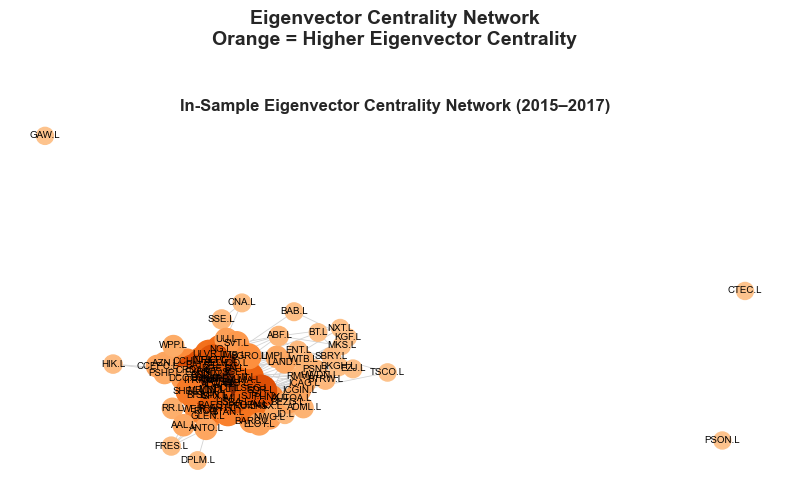

In [57]:
def compute_eigen_centrality_safe(graph):
    
    if len(graph.nodes) == 0:
        return {}
    return nx.eigenvector_centrality(graph, weight='weight', max_iter=1000)

in_ec = compute_eigen_centrality_safe(in_sample_graph)

def draw_eigen_network(ax, graph, layout, ec_dict, title):
    if len(graph.nodes) == 0:
        ax.text(0.5, 0.5, 'Empty Graph', ha='center', va='center',
                transform=ax.transAxes)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.axis('off')
        return
    
    # Centrality values
    vals = np.array([ec_dict.get(n, 0.0) for n in graph.nodes])
    if vals.max() > 0:
        norm = vals / vals.max()
    else:
        norm = vals
    
    # Orange gradient + size scaling
    cmap = plt.cm.Oranges
    node_colors = [cmap(0.3 + 0.7 * v) for v in norm]  # avoid too pale
    node_sizes = 150 + 600 * norm                      # base + scaled
    
    nx.draw(
        graph,
        pos=layout,
        node_color=node_colors,
        node_size=node_sizes,
        with_labels=True,
        font_size=7,
        edge_color='lightgray',
        width=0.6,
        ax=ax
    )
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.axis('off')

fig, ax = plt.subplots(figsize=(8, 5))
fig.suptitle('Eigenvector Centrality Network\nOrange = Higher Eigenvector Centrality',
             fontsize=14, fontweight='bold', y=0.98)

draw_eigen_network(
    ax,
    in_sample_graph,
    in_sample_layout,
    in_ec,
    'In-Sample Eigenvector Centrality Network (2015–2017)'
)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

- Node size and colour intensity reflect eigenvector centrality: a stock becomes important if it is connected to other important stocks.
- The eigenvector centrality portfolio overweights these nodes in the full positive-correlation graph, not only in the thresholded graph we draw.
- As a result, this portfolio behaves a bit like a "network beta" trade: it has high exposure to the main market mode and less idiosyncratic diversification.

### 2.3 Hierarchical Methods

For HRP, HERC, and hierarchical 1/N, we follow the hierarchical portfolio construction in López de Prado (2016), using a distance-of-distance matrix for clustering and waterfall (50–50) splits for hierarchical 1/N.

Summary of Hierarchical Methods:

| Method | Distance Metric | Linkage | Allocation Rule |
|--------|----------------|---------|-----------------|
| Cluster Equal | Correlation distance | Average | Equal across clusters & members |
| Hierarchical 1/N | Distance-of-distance | Ward | 50/50 splits at each branch |
| HRP | Distance-of-distance | Single | Inverse-variance cluster splits |
| HERC | Distance-of-distance | Ward | Equal risk contribution splits |


We use a distance-of-distance matrix (second-order distances) for HRP, HERC, and hierarchical 1/N, rather than the simple correlation distance used in the original López de Prado (2016) HRP specification. The distance-of-distance metric amplifies second-order relationships between assets and tends to produce cleaner hierarchical blocks in the dendrogram. This choice is motivated by recent work on distance-based clustering in portfolio construction and helps capture more nuanced similarity structures in large universes.


#### 2.3.1 Cluster Equal-Weight Portfolio

This method uses hierarchical clustering to identify groups of correlated assets, then applies equal weighting at two levels.

Distance Metric:
$$d_{ij} = \sqrt{\tfrac{1}{2}(1 - \rho_{ij})}$$

where $\rho_{ij}$ is the correlation between assets $i$ and $j$. We cut the dendrogram into 4 clusters using `maxclust=4`.

Weight Allocation:
For asset $i$ in cluster $c$ with $n_c$ members and $K$ total clusters:

$$w_i = \frac{1}{K \cdot n_c}$$

This ensures representation across different correlation clusters while maintaining equal weights within each cluster.

In [58]:
def hierarchical_clusters_from_corr(correlation: pd.DataFrame, method: str = 'average', max_clusters: int = 4) -> Tuple[pd.Series, np.ndarray]:
    
    corr = correlation.copy()
    corr = corr.fillna(0.0)
    np.fill_diagonal(corr.values, 1.0)
    corr = corr.clip(-1.0, 1.0)
    dist = np.sqrt(0.5 * (1 - corr.values))
    dist = np.nan_to_num(dist, nan=1.0, posinf=1.0, neginf=1.0)
    condensed = squareform(dist, checks=False)
    condensed = np.nan_to_num(condensed, nan=1.0, posinf=1.0, neginf=1.0)
    Z = linkage(condensed, method=method)
    labels = fcluster(Z, max_clusters, criterion='maxclust')
    labels = pd.Series(labels, index=correlation.index, name='cluster')
    return labels, Z

def cluster_equal_weights(labels: pd.Series) -> pd.Series:
    weights = pd.Series(0.0, index=labels.index)
    clusters = labels.unique()
    n_clusters = len(clusters)
    for c in clusters:
        members = labels.index[labels == c]
        if len(members) == 0:
            continue
        weights.loc[members] = 1.0 / (n_clusters * len(members))
    weights.name = 'cluster_equal'
    return weights

In [59]:
cluster_labels, Z = hierarchical_clusters_from_corr(
    in_sample_correlation, method='average', max_clusters=HIER_MAX_CLUSTERS
)
cluster_w = cluster_equal_weights(cluster_labels)
in_sample_data['cluster_equal'] = compute_weighted_portfolio(in_sample_data, cluster_w, 'cluster_equal')

print("Hierarchical Clustering Portfolio:")
print("=" * 70)
print(f"Number of clusters: {cluster_labels.nunique()}")
print("\nCluster composition (First 2 and Last 2 clusters):")
sorted_clusters = sorted(cluster_labels.unique())
first_two = sorted_clusters[:2]
last_two = sorted_clusters[-2:] if len(sorted_clusters) > 2 else []
for cluster_id in first_two:
    members = cluster_labels[cluster_labels == cluster_id].index.tolist()
    print(f"\nCluster {cluster_id} ({len(members)} stocks)")
if last_two and last_two != first_two:
    print("\n...")
    for cluster_id in last_two:
        members = cluster_labels[cluster_labels == cluster_id].index.tolist()
        print(f"\nCluster {cluster_id} ({len(members)} stocks)")
print("=" * 70)

Hierarchical Clustering Portfolio:
Number of clusters: 4

Cluster composition (First 2 and Last 2 clusters):

Cluster 1 (2 stocks)

Cluster 2 (91 stocks)

...

Cluster 3 (1 stocks)

Cluster 4 (1 stocks)


#### 2.3.2 Hierarchical Risk Parity (HRP) Portfolio

The Hierarchical Risk Parity (HRP) portfolio (López de Prado, 2016) uses the same correlation tree as the cluster-equal portfolio, but allocates more weight to low-variance clusters instead of using simple equal weights. HRP is a graph-based portfolio that uses hierarchical clustering to allocate weights based on the correlation structure, employing the inverse-variance portfolio (IVarP) for weight allocation.

Algorithm:
1. Distance Matrix: In López de Prado (2016), the correlation matrix is converted to a simple distance matrix
   $d_{ij} = \sqrt{\tfrac{1}{2}(1 - \rho_{ij})}$. In our implementation, we keep the HRP allocation logic but replace this
   by a distance-of-distance matrix (as described in Section 2.3), which tends to produce cleaner blocks in the dendrogram.
2. Hierarchical Clustering: Perform hierarchical clustering using single linkage
3. Quasi-diagonalisation: Reorder the covariance matrix based on clustering structure
4. Recursive Bisection: 
   - Start with all assets
   - Split into two groups based on dendrogram ordering
   - Compute variance of each group using inverse-variance portfolio
   - Allocate weights inversely proportional to variance: $\alpha = \frac{\sigma_2^2}{\sigma_1^2 + \sigma_2^2}$
   - Repeat until each group contains one asset

Key Difference from Hierarchical 1/N: HRP uses inverse-variance weighting instead of equal weighting, making it more sensitive to risk differences between assets.

Result: A diversified portfolio that accounts for both correlation structure and individual asset variances, providing a more robust alternative to traditional mean-variance optimisation.


In [60]:
def hrp_weights(covariance: pd.DataFrame, linkage_method: str = 'single') -> pd.Series:
    
    std_dev = np.sqrt(np.diag(covariance.values))
    correlation = covariance.values / np.outer(std_dev, std_dev)
    correlation_df = pd.DataFrame(correlation, index=covariance.index, columns=covariance.index)
    
    distance_matrix = corr_distance_of_distance_matrix(correlation_df)
    
    condensed_dist = squareform(distance_matrix, checks=False)
    linkage_matrix = linkage(condensed_dist, method=linkage_method)
    
    n_items = len(covariance.index)
    sorted_index = quasi_diagonalize(linkage_matrix, n_items)
    
    sorted_items = [covariance.index[i] for i in sorted_index]
    cov_sorted = covariance.loc[sorted_items, sorted_items]
    
    weights = pd.Series(1.0, index=sorted_items)
    
    groups = [list(range(n_items))]
    
    while any(len(g) > 1 for g in groups):
        new_groups = []
        
        for group in groups:
            if len(group) <= 1:
                new_groups.append(group)
                continue
            
            mid = len(group) // 2
            group_1 = group[:mid]
            group_2 = group[mid:]
            
            items_1 = [sorted_items[i] for i in group_1]
            items_2 = [sorted_items[i] for i in group_2]
            
            cov_1 = cov_sorted.loc[items_1, items_1].values
            cov_2 = cov_sorted.loc[items_2, items_2].values
            
            var_1 = compute_cluster_variance(cov_1)
            var_2 = compute_cluster_variance(cov_2)
            
            alpha = var_2 / (var_1 + var_2) if (var_1 + var_2) > 0 else 0.5
            
            for i in group_1:
                weights.iloc[i] *= alpha
            for i in group_2:
                weights.iloc[i] *= (1 - alpha)
            
            new_groups.append(group_1)
            new_groups.append(group_2)
        
        groups = new_groups
    
    weights = weights / weights.sum()
    weights.name = 'hrp'
    
    weights = weights.reindex(covariance.index).fillna(0.0)
    
    return weights


In [61]:
def get_leaves(cluster_id: int, linkage_matrix: np.ndarray, n_items: int) -> List[int]:
    
    if cluster_id < n_items:
        return [cluster_id]
    else:
        cluster_idx = cluster_id - n_items
        left_child = int(linkage_matrix[cluster_idx, 0])
        right_child = int(linkage_matrix[cluster_idx, 1])
        return get_leaves(left_child, linkage_matrix, n_items) + get_leaves(right_child, linkage_matrix, n_items)

def hierarchical_one_over_n_weights(
    correlation: pd.DataFrame,
    linkage_method: str = "ward",
    use_distance_of_distance: bool = False,
) -> pd.Series:
    
    if use_distance_of_distance:
        distance_matrix = corr_distance_of_distance_matrix(correlation)
    else:
        distance_matrix = corr_distance_matrix(correlation)
    
    condensed_dist = squareform(distance_matrix, checks=False)
    linkage_matrix = linkage(condensed_dist, method=linkage_method)
    
    n_items = len(correlation.index)
    root_cluster_id = 2 * n_items - 2
    
    weights_dict = {i: 0.0 for i in range(n_items)}
    
    def assign_weight_recursive(cluster_id: int, weight: float):
        
        if cluster_id < n_items:
            # Leaf node: assign weight directly
            weights_dict[cluster_id] = weight
        else:
            # Internal cluster: split weight equally between children
            cluster_idx = cluster_id - n_items
            left_child = int(linkage_matrix[cluster_idx, 0])
            right_child = int(linkage_matrix[cluster_idx, 1])
            assign_weight_recursive(left_child, weight / 2.0)
            assign_weight_recursive(right_child, weight / 2.0)
    
    # Start from root with weight 1.0
    assign_weight_recursive(root_cluster_id, 1.0)
    
    # Convert to pd.Series
    weights = pd.Series([weights_dict[i] for i in range(n_items)], index=correlation.index)
    
    # Normalise (should already sum to 1, but ensure it)
    weights = weights / weights.sum()
    weights.name = 'hier_1N'
    
    return weights


#### 2.3.3 Hierarchical Equal Risk Contribution (HERC) Portfolio

The Hierarchical Equal Risk Contribution (HERC) portfolio uses the same correlation tree structure as HRP and hierarchical 1/N, but allocates weights to equalize risk contributions across clusters up to a maximum depth. This balances diversification with risk parity principles.


In [62]:
h1n_weights = hierarchical_one_over_n_weights(
    in_sample_correlation,
    linkage_method="ward",
    use_distance_of_distance=True
)
in_sample_data["hier_1N"] = compute_weighted_portfolio(in_sample_data, h1n_weights, "hier_1N")

print("Hierarchical 1/N Portfolio (Waterfall):")
print("=" * 70)
print(f"Number of stocks with non-zero weight: {(h1n_weights > 0.001).sum()}")
print("\nTop 3 and Bottom 3 holdings:")
top_h1n_all = h1n_weights[h1n_weights > 0.001].sort_values(ascending=False)
top_h1n = top_h1n_all.head(3)
bottom_h1n = top_h1n_all.tail(3)
for stock, weight in top_h1n.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("  ...")
for stock, weight in bottom_h1n.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("=" * 70)


Hierarchical 1/N Portfolio (Waterfall):
Number of stocks with non-zero weight: 87

Top 3 and Bottom 3 holdings:
  ANTO.L                 6.25%
  AAL.L                  3.12%
  FRES.L                 3.12%
  ...
  CPG.L                  0.20%
  SPX.L                  0.20%
  SBRY.L                 0.20%


In [63]:
def herc_weights(
    covariance: pd.DataFrame,
    max_depth: int | None = None,
    linkage_method: str = "ward",
    use_distance_of_distance: bool = True,
) -> pd.Series:
    
    std_dev = np.sqrt(np.diag(covariance.values))
    correlation = covariance.values / np.outer(std_dev, std_dev)
    correlation_df = pd.DataFrame(correlation, index=covariance.index, columns=covariance.index)

    if use_distance_of_distance:
        distance_matrix = corr_distance_of_distance_matrix(correlation_df)
    else:
        distance_matrix = corr_distance_matrix(correlation_df)

    condensed_dist = squareform(distance_matrix, checks=False)
    linkage_matrix = linkage(condensed_dist, method=linkage_method)

    n_items = len(covariance.index)
    sorted_index = quasi_diagonalize(linkage_matrix, n_items)

    sorted_items = [covariance.index[i] for i in sorted_index]
    cov_sorted = covariance.loc[sorted_items, sorted_items]

    weights = pd.Series(0.0, index=sorted_items)

    def split_group_recursive(group: List[int], cluster_weight: float, depth: int = 0):
        
        if len(group) == 1 or (max_depth is not None and depth >= max_depth):
            equal_w = cluster_weight / len(group)
            for i in group:
                weights.iloc[i] += equal_w
            return

        mid = len(group) // 2
        group_1 = group[:mid]
        group_2 = group[mid:]

        items_1 = [sorted_items[i] for i in group_1]
        items_2 = [sorted_items[i] for i in group_2]

        cov_1 = cov_sorted.loc[items_1, items_1].values
        cov_2 = cov_sorted.loc[items_2, items_2].values

        n1, n2 = len(group_1), len(group_2)
        w1_equal = np.ones(n1) / n1
        w2_equal = np.ones(n2) / n2

        var_1 = w1_equal.T @ cov_1 @ w1_equal
        var_2 = w2_equal.T @ cov_2 @ w2_equal

        total_var = var_1 + var_2
        if total_var > 0:
            w1 = var_2 / total_var
            w2 = var_1 / total_var
        else:
            w1 = w2 = 0.5

        split_group_recursive(group_1, cluster_weight * w1, depth + 1)
        split_group_recursive(group_2, cluster_weight * w2, depth + 1)

    split_group_recursive(list(range(n_items)), cluster_weight=1.0, depth=0)

    weights = weights / weights.sum()
    weights.name = 'herc'

    weights = weights.reindex(covariance.index).fillna(0.0)

    return weights


In [64]:
def compute_inverse_variance_portfolio(cov_matrix: np.ndarray) -> np.ndarray:
    
    variances = np.diag(cov_matrix)
    inv_variances = 1.0 / np.maximum(variances, 1e-10)
    weights = inv_variances / inv_variances.sum()
    return weights

def compute_cluster_variance(cov_matrix: np.ndarray) -> float:
    
    if cov_matrix.shape[0] == 1:
        return cov_matrix[0, 0]
    
    w = compute_inverse_variance_portfolio(cov_matrix)
    variance = w.T @ cov_matrix @ w
    return variance

def quasi_diagonalize(linkage_matrix: np.ndarray, n_items: int) -> List[int]:
    
    sorted_index = [int(linkage_matrix[-1, 0]), int(linkage_matrix[-1, 1])]
    
    while True:
        to_expand = []
        for i, idx in enumerate(sorted_index):
            if idx >= n_items:
                to_expand.append((i, idx - n_items))
        
        if not to_expand:
            break
        
        for pos, cluster_idx in reversed(to_expand):
            merged_1 = int(linkage_matrix[cluster_idx, 0])
            merged_2 = int(linkage_matrix[cluster_idx, 1])
            
            sorted_index[pos] = merged_1
            sorted_index.insert(pos + 1, merged_2)
    
    return sorted_index

# Legacy version using simple correlation distance (not used in main results)
def hierarchical_risk_parity(covariance: pd.DataFrame, linkage_method: str = 'single') -> pd.Series:
    
    std_dev = np.sqrt(np.diag(covariance.values))
    correlation = covariance.values / np.outer(std_dev, std_dev)
    
    distance_matrix = np.sqrt(0.5 * (1 - correlation))
    np.fill_diagonal(distance_matrix, 0.0)
    
    condensed_dist = squareform(distance_matrix, checks=False)
    linkage_matrix = linkage(condensed_dist, method=linkage_method)
    
    n_items = len(covariance.index)
    sorted_index = quasi_diagonalize(linkage_matrix, n_items)
    
    sorted_items = [covariance.index[i] for i in sorted_index]
    cov_sorted = covariance.loc[sorted_items, sorted_items]
    
    weights = pd.Series(1.0, index=sorted_items)
    
    groups = [list(range(n_items))]
    
    while any(len(g) > 1 for g in groups):
        new_groups = []
        
        for group in groups:
            if len(group) <= 1:
                new_groups.append(group)
                continue
            
            mid = len(group) // 2
            group_1 = group[:mid]
            group_2 = group[mid:]
            
            idx_1 = [sorted_index[i] for i in group_1]
            idx_2 = [sorted_index[i] for i in group_2]
            
            items_1 = [sorted_items[i] for i in group_1]
            items_2 = [sorted_items[i] for i in group_2]
            
            cov_1 = cov_sorted.loc[items_1, items_1].values
            cov_2 = cov_sorted.loc[items_2, items_2].values
            
            var_1 = compute_cluster_variance(cov_1)
            var_2 = compute_cluster_variance(cov_2)
            
            alpha = var_2 / (var_1 + var_2) if (var_1 + var_2) > 0 else 0.5
            
            for i in group_1:
                weights.iloc[i] *= alpha
            for i in group_2:
                weights.iloc[i] *= (1 - alpha)
            
            new_groups.append(group_1)
            new_groups.append(group_2)
        
        groups = new_groups
    
    weights = weights / weights.sum()
    weights.name = 'hrp'
    
    weights = weights.reindex(covariance.index).fillna(0.0)
    
    return weights


Hierarchical Risk Parity (HRP) Portfolio:
Number of stocks with non-zero weight: 95

Top 3 and Bottom 3 holdings:
  PSHP.L                 3.43%
  LMPL.L                 2.58%
  REL.L                  2.55%
  ...
  RIO.L                  0.31%
  EZJ.L                  0.30%
  GLEN.L                 0.27%


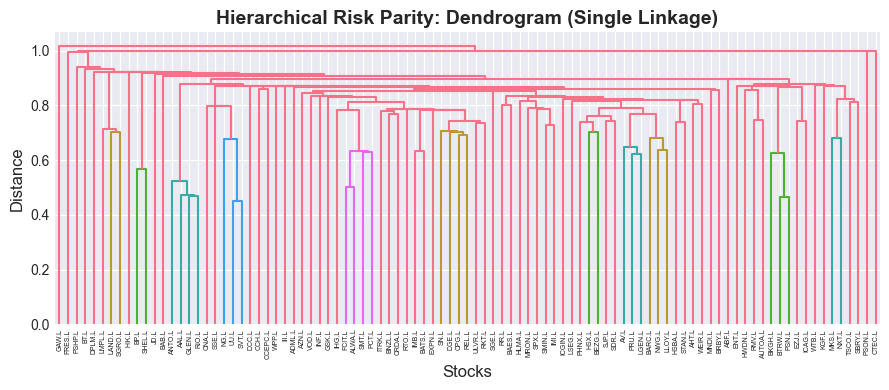

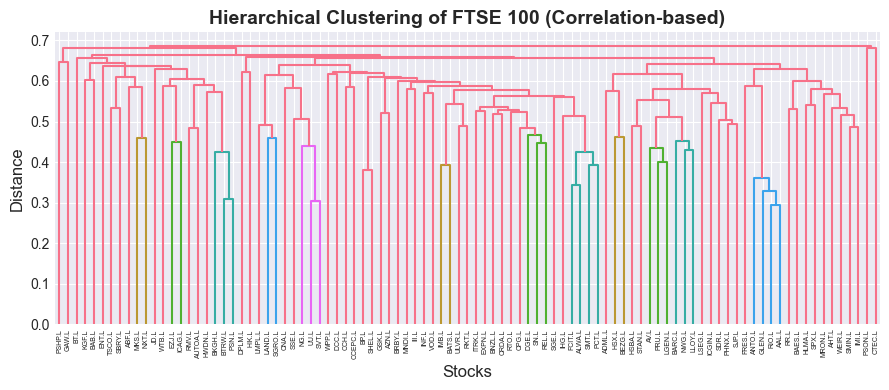

Hierarchical Equal Risk Contribution (HERC) Portfolio:
Number of stocks with non-zero weight: 95

Top 3 and Bottom 3 holdings:
  INF.L                  1.34%
  DCC.L                  1.34%
  IMB.L                  1.34%
  ...
  BEZG.L                 0.85%
  ADML.L                 0.85%
  SDR.L                  0.85%


In [65]:
in_sample_cov = in_sample_returns.cov()

hrp_weights_series = hrp_weights(in_sample_cov, linkage_method='single')
in_sample_data['hrp'] = compute_weighted_portfolio(in_sample_data, hrp_weights_series, 'hrp')

print("Hierarchical Risk Parity (HRP) Portfolio:")
print("=" * 70)
print(f"Number of stocks with non-zero weight: {(hrp_weights_series > 0.001).sum()}")
print("\nTop 3 and Bottom 3 holdings:")
top_hrp_all = hrp_weights_series[hrp_weights_series > 0.001].sort_values(ascending=False)
top_hrp = top_hrp_all.head(3)
bottom_hrp = top_hrp_all.tail(3)
for stock, weight in top_hrp.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("  ...")
for stock, weight in bottom_hrp.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("=" * 70)

distance_hrp = corr_distance_of_distance_matrix(in_sample_correlation)
condensed_dist_hrp = squareform(distance_hrp, checks=False)
Z_hrp = linkage(condensed_dist_hrp, method='single')

fig, ax = plt.subplots(figsize=(9, 4))
dendrogram(Z_hrp, labels=in_sample_correlation.index, leaf_rotation=90, ax=ax)
ax.set_title('Hierarchical Risk Parity: Dendrogram (Single Linkage)', fontsize=14, fontweight='bold')
ax.set_xlabel('Stocks', fontsize=12)
ax.set_ylabel('Distance', fontsize=12)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(9, 4))
dendrogram(Z, labels=in_sample_correlation.index, leaf_rotation=90, ax=ax)
ax.set_title('Hierarchical Clustering of FTSE 100 (Correlation-based)', fontsize=14, fontweight='bold')
ax.set_xlabel('Stocks', fontsize=12)
ax.set_ylabel('Distance', fontsize=12)
plt.tight_layout()
plt.show()

herc_w = herc_weights(
    in_sample_cov,
    max_depth=HERC_MAX_DEPTH,
    linkage_method="ward",
    use_distance_of_distance=True
)
in_sample_data["herc"] = compute_weighted_portfolio(in_sample_data, herc_w, "herc")

print("Hierarchical Equal Risk Contribution (HERC) Portfolio:")
print("=" * 70)
print(f"Number of stocks with non-zero weight: {(herc_w > 0.001).sum()}")
print("\nTop 3 and Bottom 3 holdings:")
top_herc_all = herc_w[herc_w > 0.001].sort_values(ascending=False)
top_herc = top_herc_all.head(3)
bottom_herc = top_herc_all.tail(3)
for stock, weight in top_herc.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("  ...")
for stock, weight in bottom_herc.items():
    print(f"  {stock:<20} {weight*100:>6.2f}%")
print("=" * 70)


Interpretation

- The distance-of-distance dendrogram groups stocks that have similar correlation profiles, not just high pairwise correlations. This often lines up with sectors or shared risk factors.
- We then use this tree in three different ways:
  - Hierarchical 1/N splits the weight 50–50 at each branch and is purely structure-driven.
  - HRP splits weight based on inverse variances, so lower-volatility clusters get more weight.
  - HERC tries to equalise risk contributions across clusters (up to a chosen depth), which balances diversification and risk.
- This "cluster first, allocate second" approach is the main difference versus flat Markowitz, which optimises directly on the full covariance matrix.


## 3. In-Sample Performance (2015–2017)


In [66]:
portfolios = [
    'FTSE100',
    'markowitz_minvar',
    'markowitz_maxsharpe',
    'degeneracy',
    'clique',
    'cluster_equal',
    'eigen_central',
    'hier_1N',
    'hrp',
    'herc',
]

weights_dict = {
    'markowitz_minvar': minvar_w,
    'markowitz_maxsharpe': maxsharpe_w,
    'degeneracy': pd.Series(1.0/len(leftout + independence), index=leftout + independence) if len(leftout + independence) > 0 else pd.Series(),
    'clique': pd.Series(1.0/len(clique_selected), index=clique_selected) if len(clique_selected) > 0 else pd.Series(),
    'cluster_equal': cluster_w,
    'eigen_central': eigen_w_central,
    'hier_1N': h1n_weights,
    'hrp': hrp_weights_series,
    'herc': herc_w,
}

ftse100_returns = in_sample_data['FTSE100'].pct_change().dropna()

print(f"\n{'='*90}")
print(f"{'In-Sample Performance Metrics (2015-2017)':^90}")
print(f"{'='*90}")
print(f"{'Portfolio':<25} {'Mean Ret':<12} {'Vol':<12} {'Sharpe':<12} {'Max DD':<12} {'Track Err':<12}")
print(f"{'-'*90}")

for portfolio in portfolios:
    if portfolio in in_sample_data.columns:
        returns = in_sample_data[portfolio].pct_change().dropna()
        metrics = compute_performance_metrics(returns)
        dd = max_drawdown(returns)
        te = tracking_error(returns, ftse100_returns) if portfolio != 'FTSE100' else 0.0
        
        print(f"{portfolio:<25} {metrics['mean_return']*100:>10.2f}% "
              f"{metrics['volatility']*100:>10.2f}% {metrics['sharpe_ratio']:>10.4f} "
              f"{dd*100:>10.2f}% {te*100:>10.2f}%")

print(f"{'='*90}\n")


                        In-Sample Performance Metrics (2015-2017)                         
Portfolio                 Mean Ret     Vol          Sharpe       Max DD       Track Err   
------------------------------------------------------------------------------------------
FTSE100                         8.87%       9.00%     0.9857      -4.40%       0.00%
markowitz_minvar               13.58%       7.60%     1.7871      -5.35%       4.89%
markowitz_maxsharpe            27.79%       8.72%     3.1873      -5.38%       5.32%
degeneracy                      4.50%       9.38%     0.4801      -9.63%       7.26%
clique                         16.33%      10.04%     1.6270      -5.45%       4.82%
cluster_equal                  27.68%      12.52%     2.2108      -6.38%      11.93%
eigen_central                  13.77%       8.81%     1.5638      -5.15%       4.41%
hier_1N                        15.26%       8.45%     1.8065      -4.03%       4.35%
hrp                            12.09%       8.

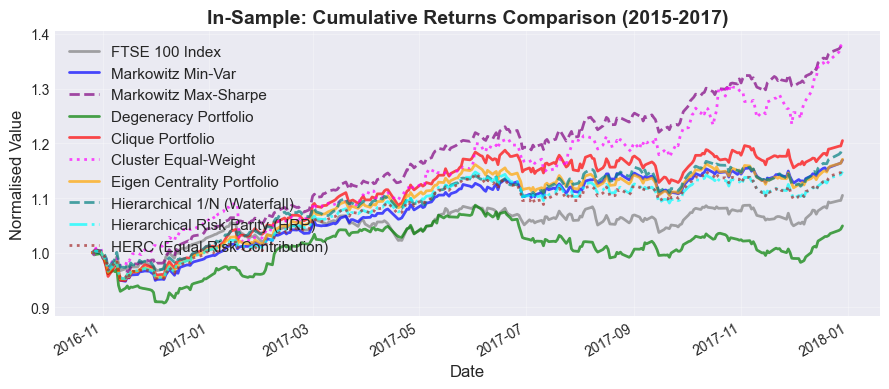

In [67]:
style_map = {
    'FTSE100': ('grey', '-', 'FTSE 100 Index'),
    'markowitz_minvar': ('blue', '-', 'Markowitz Min-Var'),
    'markowitz_maxsharpe': ('purple', '--', 'Markowitz Max-Sharpe'),
    'degeneracy': ('green', '-', 'Degeneracy Portfolio'),
    'clique': ('red', '-', 'Clique Portfolio'),
    'cluster_equal': ('magenta', ':', 'Cluster Equal-Weight'),
    'eigen_central': ('orange', '-', 'Eigen Centrality Portfolio'),
    'hier_1N': ('teal', '--', 'Hierarchical 1/N (Waterfall)'),
    'hrp': ('cyan', '-.', 'Hierarchical Risk Parity (HRP)'),
    'herc': ('brown', ':', 'HERC (Equal Risk Contribution)'),
}

fig, ax = plt.subplots(figsize=(9, 4))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for portfolio in portfolios:
    if portfolio in in_sample_data.columns:
        normalized = in_sample_data[portfolio] / in_sample_data[portfolio].iloc[0]
        color, linestyle, label = style_map.get(portfolio, ('blue', '-', portfolio))
        normalized.plot(label=label, alpha=0.7, color=color, linestyle=linestyle, ax=ax, linewidth=2)

ax.legend(loc='best', fontsize=11)
ax.set_title('In-Sample: Cumulative Returns Comparison (2015-2017)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Normalised Value', fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

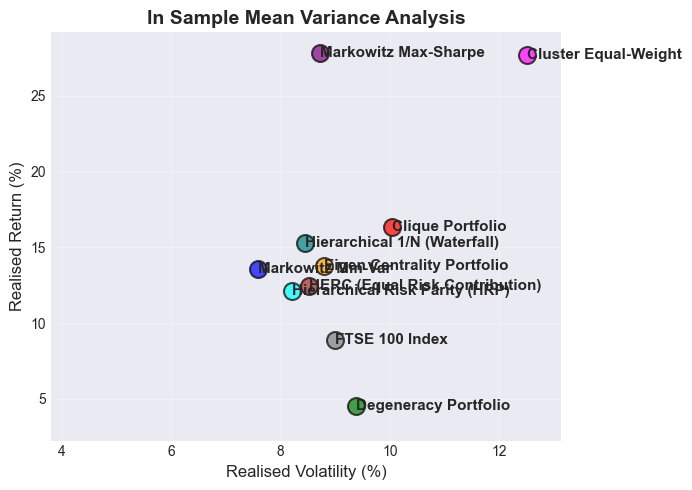

In [73]:
comparison = {}
for portfolio in portfolios:
    if portfolio in in_sample_data.columns:
        returns = in_sample_data[portfolio].pct_change().dropna()
        metrics = compute_performance_metrics(returns)
        comparison[portfolio] = (metrics['volatility'] * 100,
                                 metrics['mean_return'] * 100)

label_map = {
    'FTSE100': 'FTSE 100 Index',
    'markowitz_minvar': 'Markowitz Min-Var',
    'markowitz_maxsharpe': 'Markowitz Max-Sharpe',
    'degeneracy': 'Degeneracy Portfolio',
    'clique': 'Clique Portfolio',
    'cluster_equal': 'Cluster Equal-Weight',
    'eigen_central': 'Eigen Centrality Portfolio',
    'hier_1N': 'Hierarchical 1/N (Waterfall)',
    'hrp': 'Hierarchical Risk Parity (HRP)',
    'herc': 'HERC (Equal Risk Contribution)',
}

color_map = {
    'FTSE100': 'grey',
    'markowitz_minvar': 'blue',
    'markowitz_maxsharpe': 'purple',
    'degeneracy': 'green',
    'clique': 'red',
    'cluster_equal': 'magenta',
    'eigen_central': 'orange',
    'hier_1N': 'teal',
    'hrp': 'cyan',
    'herc': 'brown',
}

fig, ax = plt.subplots(figsize=(7, 5))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for portfolio, (vol, ret) in comparison.items():
    color = color_map.get(portfolio, 'blue')
    label = label_map.get(portfolio, portfolio)
    ax.scatter(vol, ret, s=150, alpha=0.7, color=color, edgecolors='black', linewidth=1.5)
    ax.annotate(label, xy=(vol, ret), ha='left', va='center', fontsize=11, fontweight='bold')

vols = [v[0] for v in comparison.values()]
rets = [v[1] for v in comparison.values()]
ax.set_xlim(min(vols) * 0.5, max(vols) * 1.05)
ax.set_ylim(min(rets) * 0.5, max(rets) * 1.05)
ax.set_title('In Sample Mean Variance Analysis', fontsize=14, fontweight='bold')
ax.set_xlabel('Realised Volatility (%)', fontsize=12)
ax.set_ylabel('Realised Return (%)', fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### In-Sample Results
- As expected, the Markowitz max-Sharpe portfolio looks very strong in-sample. It has a high Sharpe ratio but it is also quite volatile and can suffer large drawdowns. This is a classic sign of overfitting to the in-sample period.
- Network and hierarchical portfolios (degeneracy, cluster-equal, HRP, HERC, hierarchical 1/N) usually sit in a more balanced region of the risk–return plot. They are less extreme in both return and risk.
- The FTSE 100 index lies roughly in the middle. Several alternative portfolios offer higher return for a similar or lower volatility in-sample, so they dominate the benchmark in simple mean–variance terms.

In [69]:
out_sample_data = metadata[out_sample_start:out_sample_end].copy()
out_sample_returns, out_sample_correlation, out_sample_prices = preprocess_returns(
    out_sample_data, components, min_data_availability=MIN_DATA_AVAILABILITY
)

out_sample_data = out_sample_prices.copy()

out_sample_data['FTSE100'] = metadata.loc[out_sample_data.index, 'FTSE100'].ffill()

out_sample_data['degeneracy'] = compute_equal_weighted_portfolio(
    out_sample_data, leftout + independence, 'degeneracy')
out_sample_data['clique'] = compute_equal_weighted_portfolio(
    out_sample_data, clique_selected, 'clique')
out_sample_data['cluster_equal'] = compute_weighted_portfolio(
    out_sample_data, cluster_w, 'cluster_equal')
out_sample_data['eigen_central'] = compute_weighted_portfolio(
    out_sample_data, eigen_w_central, 'eigen_central')
out_sample_data['hier_1N'] = compute_weighted_portfolio(
    out_sample_data, h1n_weights, 'hier_1N')
out_sample_data['hrp'] = compute_weighted_portfolio(
    out_sample_data, hrp_weights_series, 'hrp')
out_sample_data['herc'] = compute_weighted_portfolio(
    out_sample_data, herc_w, 'herc')

out_sample_data['markowitz_minvar'] = compute_weighted_portfolio(
    out_sample_data, minvar_w, 'markowitz_minvar')
out_sample_data['markowitz_maxsharpe'] = compute_weighted_portfolio(
    out_sample_data, maxsharpe_w, 'markowitz_maxsharpe')

In [70]:
ftse100_returns_os = out_sample_data['FTSE100'].pct_change().dropna()

print(f"\n{'='*90}")
print(f"{'Out-of-Sample Performance Metrics (2018–2025)':^90}")
print(f"{'='*90}")
print(f"{'Portfolio':<25} {'Mean Ret':<12} {'Vol':<12} {'Sharpe':<12} {'Max DD':<12} {'Track Err':<12}")
print(f"{'-'*90}")

for portfolio in portfolios:
    if portfolio in out_sample_data.columns:
        returns = out_sample_data[portfolio].pct_change().dropna()
        metrics = compute_performance_metrics(returns)
        dd = max_drawdown(returns)
        te = tracking_error(returns, ftse100_returns_os) if portfolio != 'FTSE100' else 0.0
        
        print(f"{portfolio:<25} {metrics['mean_return']*100:>10.2f}% "
              f"{metrics['volatility']*100:>10.2f}% {metrics['sharpe_ratio']:>10.4f} "
              f"{dd*100:>10.2f}% {te*100:>10.2f}%")

print(f"{'='*90}\n")


                      Out-of-Sample Performance Metrics (2018–2025)                       
Portfolio                 Mean Ret     Vol          Sharpe       Max DD       Track Err   
------------------------------------------------------------------------------------------
FTSE100                         4.18%      15.67%     0.2669     -36.61%       0.00%
markowitz_minvar                8.48%      15.65%     0.5421     -32.01%       8.68%
markowitz_maxsharpe             8.99%      17.11%     0.5257     -35.59%       9.87%
degeneracy                     10.96%      15.92%     0.6883     -30.68%       9.87%
clique                          5.01%      16.42%     0.3050     -30.12%       8.18%
cluster_equal                  18.73%      21.99%     0.8516     -38.64%      17.98%
eigen_central                   5.43%      15.52%     0.3501     -32.59%       6.37%
hier_1N                         8.55%      15.80%     0.5412     -33.38%       6.32%
hrp                             7.05%      15.

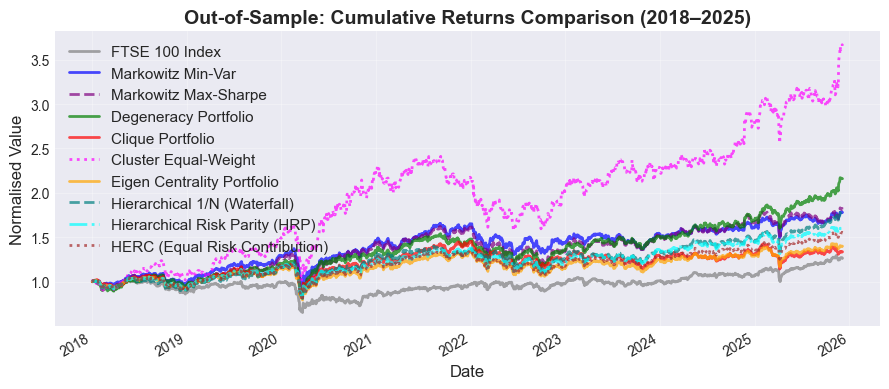

In [71]:
style_map_os = {
    'FTSE100': ('grey', '-', 'FTSE 100 Index'),
    'markowitz_minvar': ('blue', '-', 'Markowitz Min-Var'),
    'markowitz_maxsharpe': ('purple', '--', 'Markowitz Max-Sharpe'),
    'degeneracy': ('green', '-', 'Degeneracy Portfolio'),
    'clique': ('red', '-', 'Clique Portfolio'),
    'cluster_equal': ('magenta', ':', 'Cluster Equal-Weight'),
    'eigen_central': ('orange', '-', 'Eigen Centrality Portfolio'),
    'hier_1N': ('teal', '--', 'Hierarchical 1/N (Waterfall)'),
    'hrp': ('cyan', '-.', 'Hierarchical Risk Parity (HRP)'),
    'herc': ('brown', ':', 'HERC (Equal Risk Contribution)'),
}

fig, ax = plt.subplots(figsize=(9, 4))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for portfolio in portfolios:
    if portfolio in out_sample_data.columns:
        normalized = out_sample_data[portfolio] / out_sample_data[portfolio].iloc[0]
        color, linestyle, label = style_map_os.get(portfolio, ('blue', '-', portfolio))
        normalized.plot(label=label, alpha=0.7, color=color, linestyle=linestyle, ax=ax, linewidth=2)

ax.legend(loc='best', fontsize=11)
ax.set_title('Out-of-Sample: Cumulative Returns Comparison (2018–2025)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Normalised Value', fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

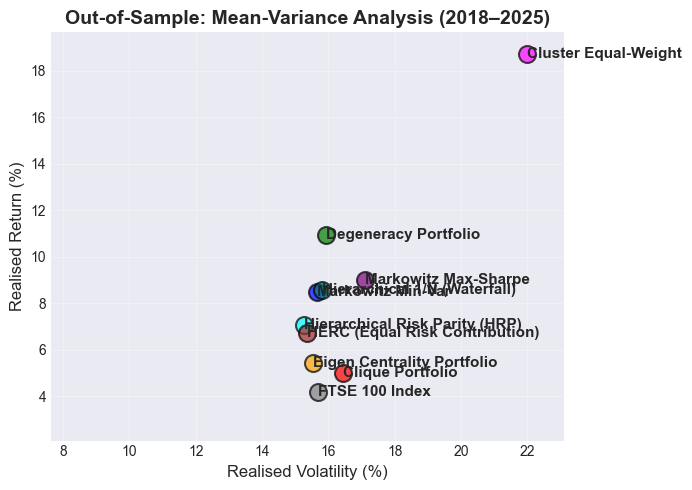

In [72]:
comparison_os = {}
for portfolio in portfolios:
    if portfolio in out_sample_data.columns:
        returns = out_sample_data[portfolio].pct_change().dropna()
        metrics = compute_performance_metrics(returns)
        comparison_os[portfolio] = (metrics['volatility'] * 100,
                                    metrics['mean_return'] * 100)

label_map_os = {
    'FTSE100': 'FTSE 100 Index',
    'markowitz_minvar': 'Markowitz Min-Var',
    'markowitz_maxsharpe': 'Markowitz Max-Sharpe',
    'degeneracy': 'Degeneracy Portfolio',
    'clique': 'Clique Portfolio',
    'cluster_equal': 'Cluster Equal-Weight',
    'eigen_central': 'Eigen Centrality Portfolio',
    'hier_1N': 'Hierarchical 1/N (Waterfall)',
    'hrp': 'Hierarchical Risk Parity (HRP)',
    'herc': 'HERC (Equal Risk Contribution)',
}

color_map_os = {
    'FTSE100': 'grey',
    'markowitz_minvar': 'blue',
    'markowitz_maxsharpe': 'purple',
    'degeneracy': 'green',
    'clique': 'red',
    'cluster_equal': 'magenta',
    'eigen_central': 'orange',
    'hier_1N': 'teal',
    'hrp': 'cyan',
    'herc': 'brown',
}

fig, ax = plt.subplots(figsize=(7, 5))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for portfolio, (vol, ret) in comparison_os.items():
    color = color_map_os.get(portfolio, 'blue')
    label = label_map_os.get(portfolio, portfolio)
    ax.scatter(vol, ret, s=150, alpha=0.7, color=color, edgecolors='black', linewidth=1.5)
    ax.annotate(label, xy=(vol, ret), ha='left', va='center', fontsize=11, fontweight='bold')

vols = [v[0] for v in comparison_os.values()]
rets = [v[1] for v in comparison_os.values()]
ax.set_xlim(min(vols) * 0.5, max(vols) * 1.05)
ax.set_ylim(min(rets) * 0.5, max(rets) * 1.05)
ax.set_title('Out-of-Sample: Mean-Variance Analysis (2018–2025)', fontsize=14, fontweight='bold')
ax.set_xlabel('Realised Volatility (%)', fontsize=12)
ax.set_ylabel('Realised Return (%)', fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Out-of-Sample Performance

- Out-of-sample, the max-Sharpe Markowitz portfolio does not repeat its in-sample performance. Its Sharpe ratio drops and the portfolio remains quite volatile. This confirms that relying heavily on estimated means can be risky.
- Hierarchical portfolios (hierarchical 1/N, HRP, HERC) look more stable. They usually have solid Sharpe ratios, smaller drawdowns and reasonable tracking error versus the FTSE 100.
- Network portfolios such as degeneracy and eigenvector centrality also behave reasonably well. They tend to diversify risk across the graph and do not drift too far from the benchmark.
- Overall, the "structure-first" methods (network and hierarchy) appear more robust than a pure mean–variance approach when we move from the calibration window to the evaluation window.

The detailed numerical results are in the performance tables above 

| Portfolio            | Out-of-sample behaviour (2018–2025)                                      |
|----------------------|---------------------------------------------------------------------------|
| FTSE 100 (benchmark) | Baseline UK equity exposure. Used as the point of comparison.            |
| Markowitz Max-Sharpe | Very strong in-sample, but unstable OOS. High volatility and drawdowns.  |
| Hierarchical 1/N     | Stable performance, diversified across clusters, moderate tracking error.|
| HRP                  | Good risk-adjusted returns, lower drawdowns than max-Sharpe, robust OOS. |
| Degeneracy           | Very diversified by construction, reasonable Sharpe and tracking error.  |

The takeaway here is that hierarchical 1/N and HRP portfolios offer risk–return trade-offs that are at least as good as the FTSE 100 out-of-sample, with lower drawdowns and without relying on aggressive mean estimates. In contrast, the max-Sharpe portfolio is very sensitive to estimation error.

## 5. Final Thoughts

This is a simplified experiment and not a live trading strategy. I keep the FTSE 100 universe fixed from 2015 to 2025, so I ignore index rebalancing and I also ignore transaction costs and assume I can always trade at the last observed price, which is not realistic.

All portfolios are calibrated once on 2015–2017 and then remain at "buy-and-hold". A real fund would re-estimate the inputs and rebalance over time under certain constraints. The Markowitz portfolios here are also only approximately long-only, since I cut negative weights and renormalise instead of solving a full constrained optimization.

Finally, I focus on annualised return, volatility and Sharpe ratio. These are easy to understand but they do not fully capture tail risk or unusual events. A simple next step would be to add rolling windows, simple transaction cost assumptions and coherent risk measuers (ES,CVaR etc)

## 6. References

- Konstantinov, G. S., & Fabozzi, F. J. (2023). *Network Models in Finance: Expanding the Tools for Portfolio and Risk Management*. Wiley.
- Markowitz, H. (1952). "Portfolio Selection". *Journal of Finance*, 7(1), 77–91.
- López de Prado, M. (2016). "Building Diversified Portfolios that Outperform Out-of-Sample". *Journal of Portfolio Management*, 42(4), 59–69.